# Flight Delay Predictor

Predicts whether a US domestic airline flight will be delayed based on basic flight characteristics. User provides information on the flight schedule, the airline, and the airports. The program returns the probability of a delay, utilizing neural network models trained on years of flight data from the US Bureau of Transportation Statistics. A summary report of the modeling procedure and general findings is available at https://github.com/Tate-G/portfolio

In [1]:
#Allow user to define flight characteristics
flight={'Month':8,
        'DayOfWeek':4,
        'Reporting_Airline':'JetBlue Airways',
        'Origin':'EWR',
        'OriginState':'NJ',
        'Dest':'BOS',
        'DestState':'MA',
        'CRSDepTime':2115,
        'CRSArrTime':2237,
        'CRSElapsedTime':82}


Likely flight delay example:
flight={'Month':8,
        'DayOfWeek':4,
        'Reporting_Airline':'JetBlue Airways',
        'Origin':'EWR',
        'OriginState':'NJ',
        'Dest':'BOS',
        'DestState':'MA',
        'CRSDepTime':2115,
        'CRSArrTime':2237,
        'CRSElapsedTime':82}

High-probability flight delay example:
flight={'Month':8,
        'DayOfWeek':4,
        'Reporting_Airline':'JetBlue Airways',
        'Origin':'BOS',
        'OriginState':'MA',
        'Dest':'EWR',
        'DestState':'NJ',
        'CRSDepTime':1846,
        'CRSArrTime':2025,
        'CRSElapsedTime':99}

Elevated probability fight delay example:
flight={'Month':8,
        'DayOfWeek':5,
        'Reporting_Airline':'United Air Lines Inc.',
        'Origin':'BNA',
        'OriginState':'TN',
        'Dest':'SFO',
        'DestState':'CA',
        'CRSDepTime':1750,
        'CRSArrTime':2032,
        'CRSElapsedTime':282}

Average delay probability example:
flight={'Month':8,
        'DayOfWeek':5,
        'Reporting_Airline':'United Air Lines Inc.',
        'Origin':'BNA',
        'OriginState':'TN',
        'Dest':'IAH',
        'DestState':'TX',
        'CRSDepTime':900,
        'CRSArrTime':1110,
        'CRSElapsedTime':130}

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Import pre-trained model and parameters

In [3]:
output_folder='7-22_May2019-Apr2021/'
model_folder=output_folder

model=tf.keras.models.load_model(model_folder+'saved_model')

from joblib import load
scaler=load(model_folder+'scaler.joblib')
train_delay_prop=load(model_folder+'Train_delay_proportion.joblib')
X_train_cols=load(model_folder+'X_train_cols.joblib')
X_vars_normalize=load(output_folder+'X_vars_normalize.joblib')
X_vars_log=load(output_folder+'X_vars_log.joblib')
X_vars_categorical=load(output_folder+'X_vars_categorical.joblib')
X_vars_hours=load(output_folder+'X_vars_hours.joblib')
X_vars_cyclical_dict=load(output_folder+'X_vars_cyclical_dict.joblib')
delay_minutes=load(output_folder+'delay_minutes.joblib')
val_probs=load(output_folder+'val_probs.joblib')

## Supporting functions

In [4]:
#function to encode cyclical time data into sin and cos variables
#usful resource at https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def convert_cyclical(df,col_name_maxval_dict):
    df_copy=df.copy()
    for col in col_name_maxval_dict.keys():
        max_value=col_name_maxval_dict[col]
        df_copy['sin('+col+')']=np.sin(2*np.pi*df_copy[col]/max_value)
        df_copy['cos('+col+')']=np.cos(2*np.pi*df_copy[col]/max_value)
        df_copy.drop(col,axis=1,inplace=True)
    return df_copy

#function to convert times to decimal hours. 
#Input format is an integer with hour in thousands and hundreds place and minutes in tens and ones place 
#(For example, in input csv 1415 corresponds to 2:15pm, convert to decimal hour 14.25)
def convert_hours(df,columns):
    df_copy=df.copy()
    for col in columns:
        df_copy[col]=df[col]//100+(df[col]%100)/60
    return df_copy


#function to normalize continuous varaibles
def normalize(X,X_vars_normalize,X_vars_log,scaler):    
    X_to_scale=X.loc[:,X_vars_normalize]
    X_to_log=X_to_scale.loc[:,X_vars_log]
    X_out=X.copy()
    
    X_to_scale[X_vars_log]=np.log(X_to_log)
    X_scaled=scaler.transform(X_to_scale)
    X_out[X_vars_normalize]=X_scaled

    return X_out


#function to add categorical variables from train that are missing in predictor
#(for example, all other airports and airlines not in the flight to be predicted)
def missing_cat_add(X_pred,X_train_cols):
    X_pred_new=X_pred.reindex(columns=X_train_cols,fill_value=0)
    
    return X_pred_new

#function to print text output
def output(prob,ave_prob,time,validation_probs):
    if prob<np.quantile(validation_probs,0.25):
        text1='Delay probability in bottom 25% of flights.'
    elif (prob>=np.quantile(validation_probs,0.8))&(prob<np.quantile(validation_probs,0.9)):
        text1='\033[91m'+'Caution:'+'\033[0m'+' Delay probability in top 20% of flights.'
    elif (prob>=np.quantile(validation_probs,0.9))&(prob<0.5):
        text1='\033[91m'+'Caution:'+'\033[0m'+' Delay probability in top 10% of flights.'
    elif prob>=0.5:
        text1='\033[91m'+'Warning:'+'\033[0m'+' Likely delayed arrival.'
    else:
        text1='Average chance of delayed arrival.'
    
    from fractions import Fraction
    prob_frac=Fraction(str(prob)).limit_denominator(10)
    ave_frac=Fraction(str(ave_prob)).limit_denominator(10)
    text2='\033[1m'+'{:.0f} in {:.0f}'.format(prob_frac.numerator,
            prob_frac.denominator)+'\033[0m'+' chance of arriving {:.0f} minutes late or more.'.format(time)
    text3='On average {:.0f} in {:.0f} flights arrive {:.0f} minutes late or more.'.format(
        ave_frac.numerator,ave_frac.denominator,time)
    
    print('******************************\n')
    print(text1)
    print(text2)
    print(text3)
    print('\n')
    print('******************************\n')
    
    
    return

## Processing and Predictions

In [5]:
X_pred=pd.DataFrame(data=flight, index=[0])
X_1hot=pd.get_dummies(X_pred,columns=X_vars_categorical)
X_hours=convert_hours(X_1hot,X_vars_hours)
X_cyc=convert_cyclical(X_hours,X_vars_cyclical_dict)
X_norm=normalize(X_cyc,X_vars_normalize,X_vars_log,scaler)
X_padded=missing_cat_add(X_norm,X_train_cols)
prob=model.predict_proba(X_padded)

output(prob[0][0],train_delay_prop,delay_minutes,val_probs)

******************************

5 in 9 chance of arriving 15 minutes late or more.
On average 1 in 7 flights arrive 15 minutes late or more.


******************************



## Cross-Validated Performance
The plot below shows ROC AUC metrics for models tested from January 2019 to May 2021. Models were trained on moving 2-year windows of flight data ending 4 months before the test data. The baseline randomly guesses delays in proportion with delays in the test data. Models were noticeably better than the baseline for all but April 2020 at the height of pandemic disruptions.

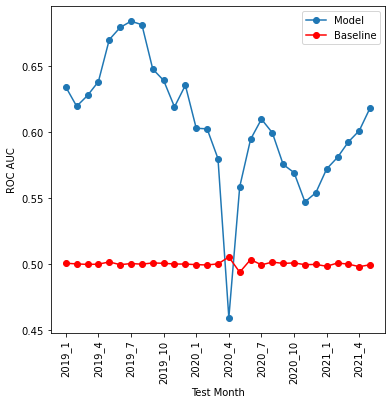

In [6]:
metrics=pd.read_csv('7-22_Jan2019-May2021_cross_val/metrics.csv')
dummy_metrics=pd.read_csv('7-22_Jan2019-May2021_cross_val/dummy_metrics.csv')

import matplotlib.pyplot as plt

f,ax=plt.subplots(1,figsize=(6,6))
plt.plot(metrics['Test_data'],metrics['ROC_AUC'],'o-',label='Model')
plt.plot(dummy_metrics['Test_data'],dummy_metrics['ROC_AUC'],'ro-',label='Baseline')
plt.xticks(metrics['Test_data'][::3],rotation='vertical')
ax.set_xlabel('Test Month')
ax.set_ylabel('ROC AUC')
ax.legend()
plt.show()

## Potential Delay Prevention
Simple adjustments to flight times based on my delay probabilities could save the US overall about 2 billion dollars a year, with 1 billion dollars of those annual savings going to passengers. This is possible by adding just 15 minutes to the arrival time of only the top 10% most likely flight delays. In the cross-validation below over data from 2019-2021, this strategy would reduce the total number of flight delays by about 5-6%. Given that flight delays cost the US 33 billion dollars and US passengers alone 18 billion dollars in 2019, a 5-6% flight delay reduction has a clear chance to save billions of dollars.

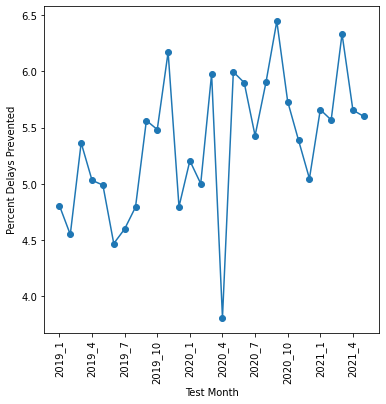

In [7]:
f,ax=plt.subplots(1,figsize=(6,6))
plt.plot(metrics['Test_data'],100*metrics['Delays_Prevented'],'o-')
plt.xticks(metrics['Test_data'][::3],rotation='vertical')
ax.set_xlabel('Test Month')
ax.set_ylabel('Percent Delays Prevented')
plt.show()